# 1. Load Library

In this section we import all the necessary libraries.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
import random
import pickle

from scipy.sparse import csr_matrix, vstack
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from xgboost import XGBRegressor                  # XGBoost for GPU processing
from sklearn.preprocessing import OneHotEncoder     # Support Sparse Matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay   # Classification metrics

print('Libraries loaded successfully')

Libraries loaded successfully


# 2. Load Dataset

Load the dataset (e.g., a CSV file) and preview it.

In [2]:
# Download from Kaggle or load preprocessed data
current_path = None
if not current_path:
    path = kagglehub.dataset_download("samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc")

    files = os.listdir(path)
    csv_path = os.path.join(path, 'GDSC_Cleaned.csv')
    df = pd.read_csv(csv_path)
    df.head()

print("Path to dataset files:", path)

Path to dataset files: C:\Users\LiuXirui\.cache\kagglehub\datasets\samiraalipour\genomics-of-drug-sensitivity-in-cancer-gdsc\versions\2


In [3]:
print(df.shape)
df.head()

(214880, 19)


,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.592660,-1.516647,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.734047,-0.807232,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.582439,-1.570016,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


In [4]:
# check drug id = 1003 drug name
drug_id = 1003
drug_name = df[df['DRUG_ID'] == drug_id]['DRUG_NAME'].values[0]
print(f"Drug ID: {drug_id}, Drug Name: {drug_name}")

Drug ID: 1003, Drug Name: Camptothecin


In [33]:
# Data preprocessing
categorical_features = ['GDSC Tissue descriptor 1',
                        'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)',
                        'TARGET', 'TARGET_PATHWAY']
full_features = categorical_features + ['Microsatellite instability Status (MSI)', 'CNA', 'Gene Expression', 'Methylation']

data = df.copy()
# Filter highly skewed drugs: skewness of LN_IC50 should be ≤ 2
drug_skew = data.groupby("DRUG_NAME")["LN_IC50"].skew()
abs_skews = drug_skew.abs()
threshold = 2
low_skew_drugs = abs_skews[abs_skews <= threshold].index
data_filtered = data[data["DRUG_NAME"].isin(low_skew_drugs)].copy()
print(f"Using absolute skewness ≤ {threshold:.2f} as low‑skew cutoff.")
all_drugs = data["DRUG_NAME"].unique()
print(f"Filter {len(all_drugs) - len(low_skew_drugs)} drugs.")

# Could be adjusted to use all features
data_filtered = data_filtered[data_filtered['DRUG_ID'] == 1003]
X = data_filtered[full_features]
# X = data_filtered[categorical_features]

# One-Hot Encoding for X
X_encoder = OneHotEncoder(sparse_output=True)
X_encoded = X_encoder.fit_transform(X)
# X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Define 3‑class function based on Z_SCORE
def z_to_label(z):
    if z <= -1:
        return "Sensitive"
    elif z >= 1:
        return "Resistant"
    else:
        return "Intermediate"
# Apply and store labels in y
data_filtered["Response_Label"] = data_filtered["Z_SCORE"].apply(z_to_label)
y = data_filtered["Response_Label"]
print(y.value_counts())

Using absolute skewness ≤ 2.00 as low‑skew cutoff.
Filter 6 drugs.
Response_Label
Intermediate    627
Resistant       171
Sensitive       169
Name: count, dtype: int64


# 3. Define Base Learner

Define the base learner that will be used in the different learning methods. For example, a simple Logistic Regression classifier.

In [34]:
offline_seed = 42

"""
# Use XGBoost regressor, optimized hyperparameters for whole dataset
base_learner = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,                 # Subsample ratio of the training instances
    colsample_bytree=1.0,          # Subsample ratio of columns when constructing each tree
    # early_stopping_rounds=10,      # Early stopping rounds for validation set
    # eval_metric="rmse",            # Evaluation metric for early stopping
    random_state=offline_seed,
)"""

# Define the base learner as random forest
base_learner = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=offline_seed,
)

print('Base learner defined:')
print(base_learner)

Base learner defined:
RandomForestClassifier(max_depth=10, random_state=42)


# 4. Offline Learning Method

Implement the offline (batch) learning method where the base learner is trained on the entire dataset.

c:\Users\LiuXirui\miniforge3\envs\xiruil-base\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7113
Precision: 0.5999
Recall: 0.7113
F1 Score: 0.6302


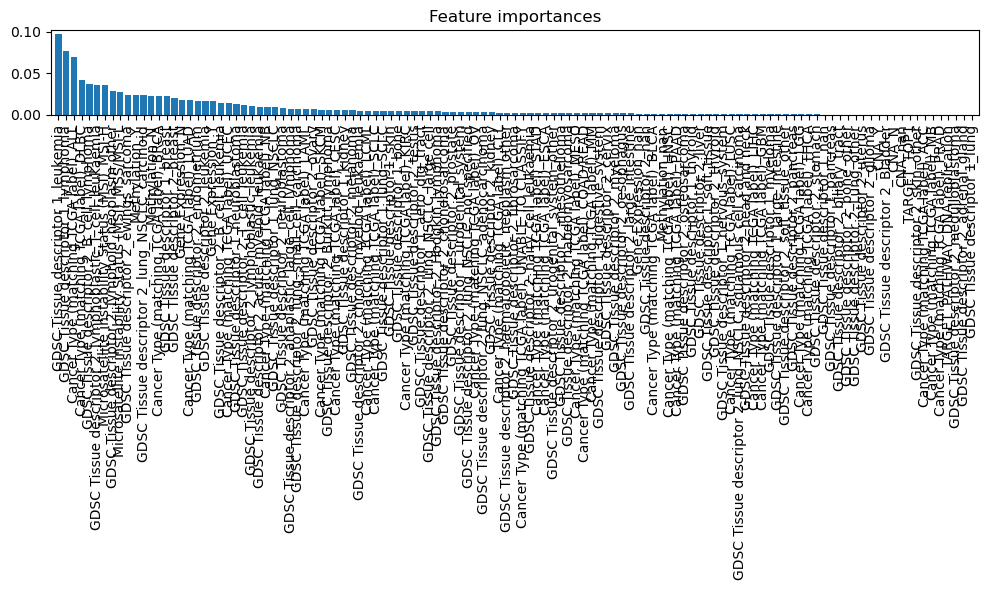

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=offline_seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=offline_seed, stratify=y_train)

# Train the base learner
base_learner.fit(X_train, y_train)

# evaluate the model
y_pred = base_learner.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # 多分类使用weighted
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Visualize the feature importance
importances = base_learner.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_encoder.get_feature_names_out(X.columns)[indices]
# features = X_encoded.columns[indices]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_encoded.shape[1]), importances[indices], align="center")
plt.xticks(range(X_encoded.shape[1]), features, rotation=90)
plt.xlim([-1, X_encoded.shape[1]])
plt.tight_layout()
plt.show()

# 5. Passive Learning Method

Implement the passive learning method. This method randomly select instances from sample space for model training.

In [46]:
def random_sampling(X, y, n_samples, random_state):
    """
    Perform random sampling from the dataset in a sparse-compatible way.
    
    Parameters:
    -----------
    X : {array-like, sparse matrix, dataframe} of shape (n_samples, n_features)
        The input samples
    y : array-like of shape (n_samples,)
        The target values
    n_samples : int
        Number of samples to select
    random_state : int or None, optional (default=None)
        Controls the randomness of the sampling
        
    Returns:
    --------
    X_sampled : selected samples
    X_remaining : remaining samples
    y_sampled : selected target values
    y_remaining : remaining target values
    """
    np.random.seed(random_state)
    indices = np.random.permutation(X.shape[0])
    sample_idx = indices[:n_samples]
    remaining_idx = indices[n_samples:]

    if hasattr(X, 'iloc'):  # pandas DataFrame
        X_sampled = X.iloc[sample_idx]
        X_remaining = X.iloc[remaining_idx]
    else:  # numpy array
        X_sampled = X[sample_idx]
        X_remaining = X[remaining_idx]

    if hasattr(y, 'iloc'):  # pandas DataFrame
        y_sampled = y.iloc[sample_idx]
        y_remaining = y.iloc[remaining_idx]
    else:
        y_sampled = y[sample_idx]
        y_remaining = y[remaining_idx]

    return X_sampled, X_remaining, y_sampled, y_remaining

In [47]:
test_size = 0.2             # Percentage of data for testing
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments

accuracy_passive = []
f1_passive = []

# Passive learning
for seed in range(n_runs):
    base_learner = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=seed,
    )

    # Split the data into training and testing sets
    X_train_pool, X_test, y_train_pool, y_test = train_test_split(
        X_encoded, y, test_size=test_size, random_state=seed, stratify=y)
    X_train, X_pool, y_train, y_pool = train_test_split(
        X_train_pool, y_train_pool, train_size=initial_train_size, random_state=seed, stratify=y_train_pool)

    max_samples = int(X_train_pool.shape[0] * max_train_size)
    overall_accuracy = []
    overall_f1 = []

    while X_train.shape[0] < max_samples:
        model = base_learner.fit(X_train, y_train)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        overall_accuracy.append(accuracy_score(y_test, y_pred))
        overall_f1.append(f1_score(y_test, y_pred, average='weighted'))

        # Randomly select a sample from the training set
        X_new, X_pool, y_new, y_pool = random_sampling(
            X_pool, y_pool, n_samples=1, random_state=seed)

        # Update the training set with the new sample
        X_train = vstack([X_train, X_new])
        y_train = pd.concat([y_train, y_new], ignore_index=True)

        # Verbose output
        if X_train.shape[0] % 100 == 0:
            print(f"Training size: {X_train.shape[0]}, Accuracy: {overall_accuracy[-1]:.2f}, F1: {overall_f1[-1]:.2f}")

    accuracy_passive.append(overall_accuracy)
    f1_passive.append(overall_f1)
    print(f"Seed {seed} done")

# Save results
with open('./results/passive_learning_results.pkl', 'wb') as f:
    pickle.dump((accuracy_passive, f1_passive), f)

Training size: 100, Accuracy: 0.65, F1: 0.57
Training size: 200, Accuracy: 0.64, F1: 0.56
Training size: 300, Accuracy: 0.64, F1: 0.56
Training size: 400, Accuracy: 0.67, F1: 0.60
Training size: 500, Accuracy: 0.66, F1: 0.59
Training size: 600, Accuracy: 0.70, F1: 0.62
Training size: 700, Accuracy: 0.72, F1: 0.64
Seed 0 done
Training size: 100, Accuracy: 0.57, F1: 0.52
Training size: 200, Accuracy: 0.70, F1: 0.62
Training size: 300, Accuracy: 0.70, F1: 0.64
Training size: 400, Accuracy: 0.70, F1: 0.63
Training size: 500, Accuracy: 0.69, F1: 0.62
Training size: 600, Accuracy: 0.69, F1: 0.62
Training size: 700, Accuracy: 0.69, F1: 0.62
Seed 1 done
Training size: 100, Accuracy: 0.68, F1: 0.61
Training size: 200, Accuracy: 0.68, F1: 0.60
Training size: 300, Accuracy: 0.69, F1: 0.62
Training size: 400, Accuracy: 0.70, F1: 0.63
Training size: 500, Accuracy: 0.68, F1: 0.60
Training size: 600, Accuracy: 0.67, F1: 0.61
Training size: 700, Accuracy: 0.68, F1: 0.60
Seed 2 done
Training size: 100,

Mean Accuracy of the model: 0.6948
Mean F1 Score of the model: 0.6141


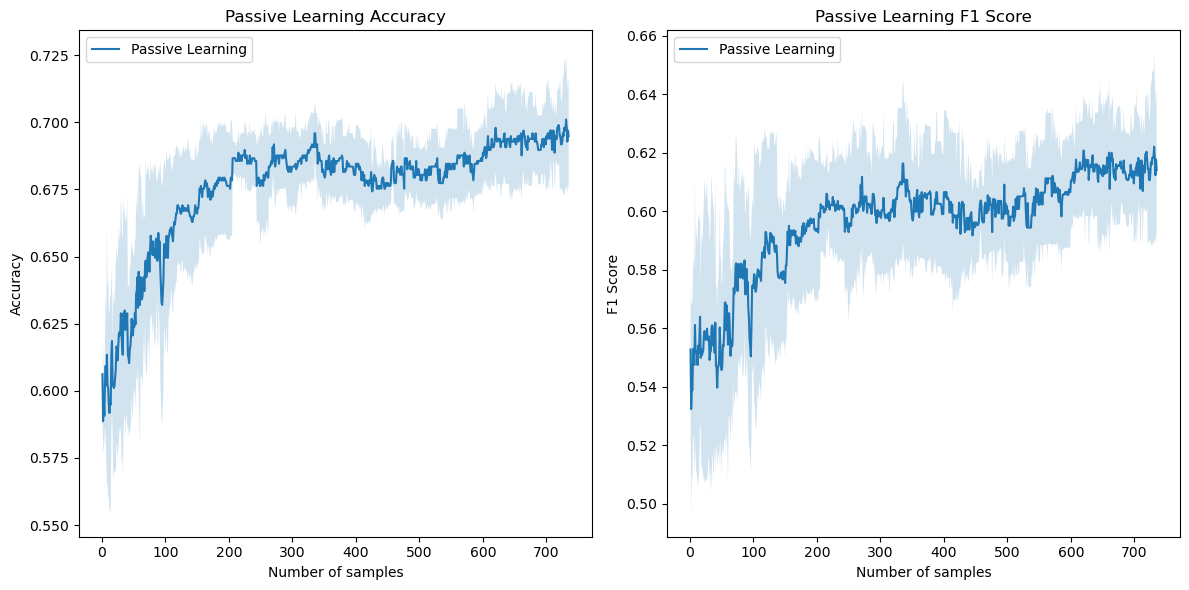

In [62]:
# Calculate the mean and standard deviation of accuracy and F1 scores
accuracy_passive = np.array(accuracy_passive)
mean_accuracy_passive = np.mean(accuracy_passive, axis=0)
std_accuracy_passive = np.std(accuracy_passive, axis=0)
f1_passive = np.array(f1_passive)
mean_f1_passive = np.mean(f1_passive, axis=0)
std_f1_passive = np.std(f1_passive, axis=0)
print(f'Mean Accuracy of the model: {mean_accuracy_passive[-1]:.4f}')
print(f'Mean F1 Score of the model: {mean_f1_passive[-1]:.4f}')

# Plot the results (updated for classification metrics)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(mean_accuracy_passive) + 1), mean_accuracy_passive, label='Passive Learning')
plt.fill_between(range(1, len(mean_accuracy_passive) + 1), 
                 mean_accuracy_passive - std_accuracy_passive,
                 mean_accuracy_passive + std_accuracy_passive, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.title('Passive Learning Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(mean_f1_passive) + 1), mean_f1_passive, label='Passive Learning')
plt.fill_between(range(1, len(mean_f1_passive) + 1),
                 mean_f1_passive - std_f1_passive,
                 mean_f1_passive + std_f1_passive, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('F1 Score')
plt.title('Passive Learning F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/Passive_Learning_Results.png', dpi=300)
plt.show()

# 6. Active Learning Method

### 6.1 Uncertainty based method


In [69]:
def uncertainty_sampling(model, X, y, n_samples, random_state=None):
    """
    Perform uncertainty sampling from the dataset based on least confidence.
    
    Parameters:
    -----------
    model : classifier object
        The trained classifier with predict_proba method
    X : {array-like, sparse matrix, dataframe} of shape (n_samples, n_features)
        The input samples
    y : array-like of shape (n_samples,)
        The target values
    n_samples : int
        Number of samples to select
    random_state : int or None, optional (default=None)
        Controls the randomness for tie-breaking
        
    Returns:
    --------
    X_sampled : selected samples
    X_remaining : remaining samples
    y_sampled : selected target values
    y_remaining : remaining target values
    """
    # Calculate prediction probabilities
    y_pred = model.predict_proba(X)
    
    # Calculate least confidence (1 - max class probability)
    max_probs = np.max(y_pred, axis=1)
    least_confidence = 1 - max_probs
    
    # Handle ties with random state
    if random_state is not None:
        np.random.seed(random_state)
    
    # Get indices sorted by least confidence (descending) with random tie-breaking
    sample_idx = np.lexsort((np.random.random(len(least_confidence)), -least_confidence))
    
    # Split indices into sampled and remaining
    sampled_idx = sample_idx[:n_samples]
    remaining_idx = sample_idx[n_samples:]

    # Handle different input types (pandas vs numpy)
    if hasattr(X, 'iloc'):  # pandas DataFrame
        X_sampled = X.iloc[sampled_idx]
        X_remaining = X.iloc[remaining_idx]
    else:  # numpy array or sparse matrix
        X_sampled = X[sampled_idx]
        X_remaining = X[remaining_idx]

    if hasattr(y, 'iloc'):  # pandas Series/DataFrame
        y_sampled = y.iloc[sampled_idx]
        y_remaining = y.iloc[remaining_idx]
    else:
        y_sampled = y[sampled_idx]
        y_remaining = y[remaining_idx]

    return X_sampled, X_remaining, y_sampled, y_remaining

In [70]:
test_size = 0.2             # Percentage of data for testing
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments

accuracy_uncertainty = []
f1_uncertainty = []

for seed in range(n_runs):
    base_learner = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=seed,
    )

    # Split the data into training and testing sets
    X_train_pool, X_test, y_train_pool, y_test = train_test_split(
        X_encoded, y, test_size=test_size, random_state=seed, stratify=y)
    X_train, X_pool, y_train, y_pool = train_test_split(
        X_train_pool, y_train_pool, train_size=initial_train_size, random_state=seed, stratify=y_train_pool)

    max_samples = int(X_train_pool.shape[0] * max_train_size)
    overall_accuracy = []
    overall_f1 = []

    while X_train.shape[0] < max_samples:
        model = base_learner.fit(X_train, y_train)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        overall_accuracy.append(accuracy_score(y_test, y_pred))
        overall_f1.append(f1_score(y_test, y_pred, average='weighted'))

        # Randomly select a sample from the training set
        X_new, X_pool, y_new, y_pool = uncertainty_sampling(
            model, X_pool, y_pool, n_samples=1, random_state=seed)

        # Update the training set with the new sample
        X_train = vstack([X_train, X_new])
        y_train = pd.concat([y_train, y_new], ignore_index=True)

        # Verbose output
        if X_train.shape[0] % 100 == 0:
            print(f"Training size: {X_train.shape[0]}, Accuracy: {overall_accuracy[-1]:.2f}, F1: {overall_f1[-1]:.2f}")

    accuracy_uncertainty.append(overall_accuracy)
    f1_uncertainty.append(overall_f1)
    print(f"Seed {seed} done")

# Save results
with open('./results/uncertainty_sampling_results.pkl', 'wb') as f:
    pickle.dump((accuracy_uncertainty, f1_uncertainty), f)

Training size: 100, Accuracy: 0.71, F1: 0.63
Training size: 200, Accuracy: 0.72, F1: 0.63
Training size: 300, Accuracy: 0.72, F1: 0.63
Training size: 400, Accuracy: 0.72, F1: 0.64
Training size: 500, Accuracy: 0.72, F1: 0.65
Training size: 600, Accuracy: 0.73, F1: 0.65
Training size: 700, Accuracy: 0.71, F1: 0.63
Seed 0 done
Training size: 100, Accuracy: 0.61, F1: 0.58
Training size: 200, Accuracy: 0.68, F1: 0.61
Training size: 300, Accuracy: 0.71, F1: 0.63
Training size: 400, Accuracy: 0.72, F1: 0.66
Training size: 500, Accuracy: 0.69, F1: 0.62
Training size: 600, Accuracy: 0.70, F1: 0.63
Training size: 700, Accuracy: 0.70, F1: 0.63
Seed 1 done
Training size: 100, Accuracy: 0.68, F1: 0.61
Training size: 200, Accuracy: 0.67, F1: 0.60
Training size: 300, Accuracy: 0.66, F1: 0.60
Training size: 400, Accuracy: 0.67, F1: 0.60
Training size: 500, Accuracy: 0.67, F1: 0.60
Training size: 600, Accuracy: 0.67, F1: 0.60
Training size: 700, Accuracy: 0.67, F1: 0.58
Seed 2 done
Training size: 100,

Mean Accuracy of the model: 0.6969
Mean F1 Score of the model: 0.6163


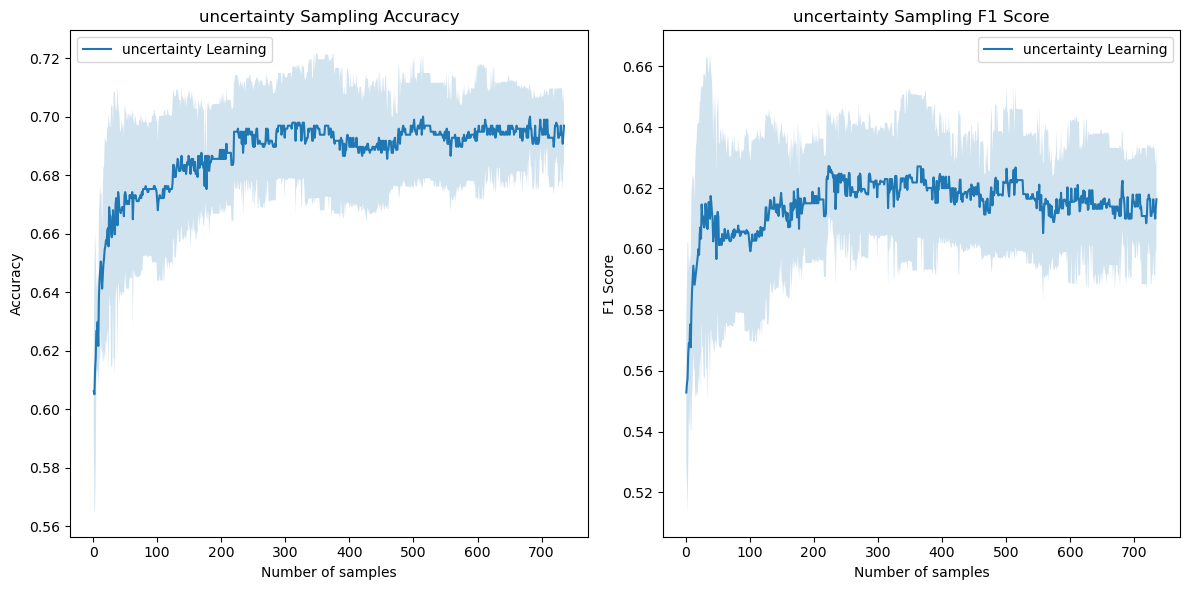

In [71]:
# Calculate the mean and standard deviation of accuracy and F1 scores
accuracy_uncertainty = np.array(accuracy_uncertainty)
mean_accuracy_uncertainty = np.mean(accuracy_uncertainty, axis=0)
std_accuracy_uncertainty = np.std(accuracy_uncertainty, axis=0)
f1_uncertainty = np.array(f1_uncertainty)
mean_f1_uncertainty = np.mean(f1_uncertainty, axis=0)
std_f1_uncertainty = np.std(f1_uncertainty, axis=0)
print(f'Mean Accuracy of the model: {mean_accuracy_uncertainty[-1]:.4f}')
print(f'Mean F1 Score of the model: {mean_f1_uncertainty[-1]:.4f}')

# Plot the results (updated for classification metrics)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(mean_accuracy_uncertainty) + 1), mean_accuracy_uncertainty, label='uncertainty Learning')
plt.fill_between(range(1, len(mean_accuracy_uncertainty) + 1), 
                 mean_accuracy_uncertainty - std_accuracy_uncertainty,
                 mean_accuracy_uncertainty + std_accuracy_uncertainty, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.title('uncertainty Sampling Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(mean_f1_uncertainty) + 1), mean_f1_uncertainty, label='uncertainty Learning')
plt.fill_between(range(1, len(mean_f1_uncertainty) + 1),
                 mean_f1_uncertainty - std_f1_uncertainty,
                 mean_f1_uncertainty + std_f1_uncertainty, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('F1 Score')
plt.title('uncertainty Sampling F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/uncertainty_Sampling_Results.png', dpi=300)
plt.show()

### 6.2 Query by committee

In [63]:
def query_by_committee(random_forest, X, y, n_samples, method='soft_vote', random_state=None):
    """
    Query samples from the dataset based on committee disagreement.
    
    Parameters:
    -----------
    random_forest : RandomForestClassifier
        A trained random forest model used as the committee
    X : {array-like, sparse matrix, dataframe} of shape (n_samples, n_features)
        The input samples
    y : array-like of shape (n_samples,)
        The target values
    n_samples : int
        Number of samples to select
    method : str, optional (default='soft_vote')
        Method for calculating disagreement: 'soft_vote' or 'hard_vote'
    random_state : int or None, optional (default=None)
        Controls the randomness for tie-breaking
        
    Returns:
    --------
    X_sampled : selected samples
    X_remaining : remaining samples
    y_sampled : selected target values
    y_remaining : remaining target values
    """
    # Handle random state for tie-breaking
    if random_state is not None:
        np.random.seed(random_state)
    
    if method == 'hard_vote':
        pass
    elif method == 'soft_vote':
        committee_predictions = np.array([tree.predict_proba(X) for tree in random_forest.estimators_])
        vote_prob = np.mean(committee_predictions, axis=0) + 1e-10
        committee_entropy = -np.sum(vote_prob * np.log(vote_prob), axis=1)
    
    # Get indices sorted by entropy (descending) with random tie-breaking
    sample_idx = np.lexsort((np.random.random(len(committee_entropy)), -committee_entropy))
    
    # Split indices into sampled and remaining
    sampled_idx = sample_idx[:n_samples]
    remaining_idx = sample_idx[n_samples:]

    # Handle different input types (pandas vs numpy)
    if hasattr(X, 'iloc'):  # pandas DataFrame
        X_sampled = X.iloc[sampled_idx]
        X_remaining = X.iloc[remaining_idx]
    else:  # numpy array or sparse matrix
        X_sampled = X[sampled_idx]
        X_remaining = X[remaining_idx]

    if hasattr(y, 'iloc'):  # pandas Series/DataFrame
        y_sampled = y.iloc[sampled_idx]
        y_remaining = y.iloc[remaining_idx]
    else:
        y_sampled = y[sampled_idx]
        y_remaining = y[remaining_idx]

    return X_sampled, X_remaining, y_sampled, y_remaining

In [65]:
test_size = 0.2             # Percentage of data for testing
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments

accuracy_QBC = []
f1_QBC = []

for seed in range(n_runs):
    base_learner = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=seed,
    )

    # Split the data into training and testing sets
    X_train_pool, X_test, y_train_pool, y_test = train_test_split(
        X_encoded, y, test_size=test_size, random_state=seed, stratify=y)
    X_train, X_pool, y_train, y_pool = train_test_split(
        X_train_pool, y_train_pool, train_size=initial_train_size, random_state=seed, stratify=y_train_pool)

    max_samples = int(X_train_pool.shape[0] * max_train_size)
    overall_accuracy = []
    overall_f1 = []

    while X_train.shape[0] < max_samples:
        model = base_learner.fit(X_train, y_train)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        overall_accuracy.append(accuracy_score(y_test, y_pred))
        overall_f1.append(f1_score(y_test, y_pred, average='weighted'))

        # Randomly select a sample from the training set
        X_new, X_pool, y_new, y_pool = query_by_committee(
            model, X_pool, y_pool, n_samples=1, method='soft_vote', random_state=seed)

        # Update the training set with the new sample
        X_train = vstack([X_train, X_new])
        y_train = pd.concat([y_train, y_new], ignore_index=True)

        # Verbose output
        if X_train.shape[0] % 100 == 0:
            print(f"Training size: {X_train.shape[0]}, Accuracy: {overall_accuracy[-1]:.2f}, F1: {overall_f1[-1]:.2f}")

    accuracy_QBC.append(overall_accuracy)
    f1_QBC.append(overall_f1)
    print(f"Seed {seed} done")

# Save results
with open('./results/query_by_committee_results.pkl', 'wb') as f:
    pickle.dump((accuracy_QBC, f1_QBC), f)

Training size: 100, Accuracy: 0.62, F1: 0.56
Training size: 200, Accuracy: 0.64, F1: 0.58
Training size: 300, Accuracy: 0.71, F1: 0.63
Training size: 400, Accuracy: 0.73, F1: 0.65
Training size: 500, Accuracy: 0.73, F1: 0.65
Training size: 600, Accuracy: 0.73, F1: 0.66
Training size: 700, Accuracy: 0.73, F1: 0.65
Seed 0 done
Training size: 100, Accuracy: 0.65, F1: 0.59
Training size: 200, Accuracy: 0.68, F1: 0.61
Training size: 300, Accuracy: 0.69, F1: 0.62
Training size: 400, Accuracy: 0.69, F1: 0.62
Training size: 500, Accuracy: 0.69, F1: 0.64
Training size: 600, Accuracy: 0.71, F1: 0.65
Training size: 700, Accuracy: 0.69, F1: 0.62
Seed 1 done
Training size: 100, Accuracy: 0.68, F1: 0.66
Training size: 200, Accuracy: 0.70, F1: 0.63
Training size: 300, Accuracy: 0.70, F1: 0.63
Training size: 400, Accuracy: 0.68, F1: 0.61
Training size: 500, Accuracy: 0.70, F1: 0.63
Training size: 600, Accuracy: 0.70, F1: 0.63
Training size: 700, Accuracy: 0.69, F1: 0.61
Seed 2 done
Training size: 100,

Mean Accuracy of the model: 0.6938
Mean F1 Score of the model: 0.6155


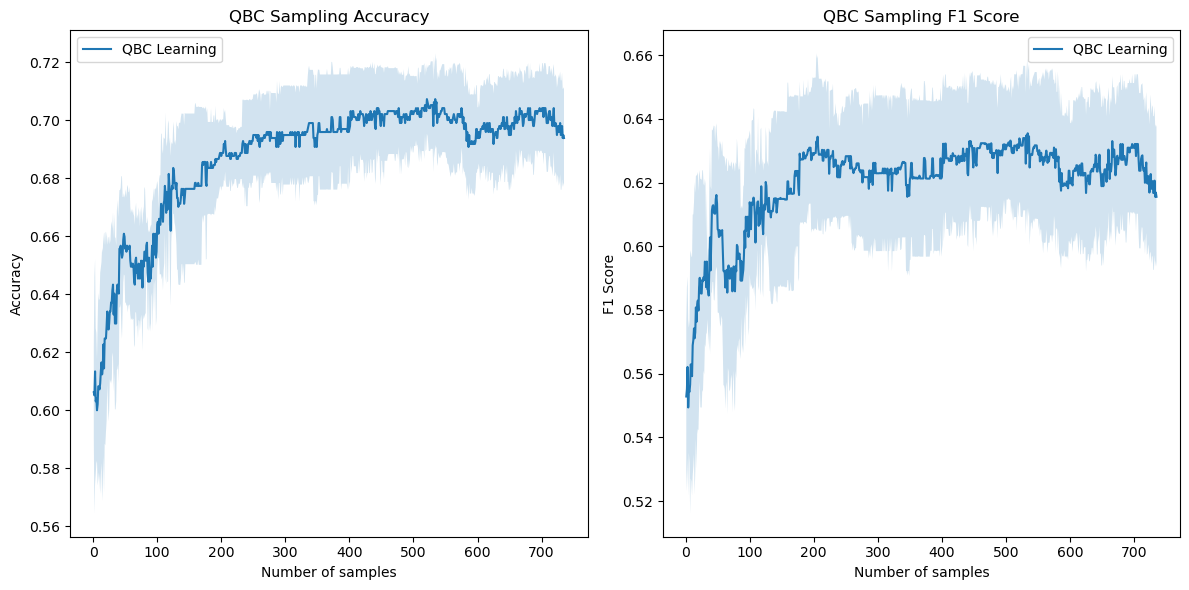

In [66]:
# Calculate the mean and standard deviation of accuracy and F1 scores
accuracy_QBC = np.array(accuracy_QBC)
mean_accuracy_QBC = np.mean(accuracy_QBC, axis=0)
std_accuracy_QBC = np.std(accuracy_QBC, axis=0)
f1_QBC = np.array(f1_QBC)
mean_f1_QBC = np.mean(f1_QBC, axis=0)
std_f1_QBC = np.std(f1_QBC, axis=0)
print(f'Mean Accuracy of the model: {mean_accuracy_QBC[-1]:.4f}')
print(f'Mean F1 Score of the model: {mean_f1_QBC[-1]:.4f}')

# Plot the results (updated for classification metrics)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(mean_accuracy_QBC) + 1), mean_accuracy_QBC, label='QBC Learning')
plt.fill_between(range(1, len(mean_accuracy_QBC) + 1), 
                 mean_accuracy_QBC - std_accuracy_QBC,
                 mean_accuracy_QBC + std_accuracy_QBC, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.title('QBC Sampling Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(mean_f1_QBC) + 1), mean_f1_QBC, label='QBC Learning')
plt.fill_between(range(1, len(mean_f1_QBC) + 1),
                 mean_f1_QBC - std_f1_QBC,
                 mean_f1_QBC + std_f1_QBC, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('F1 Score')
plt.title('QBC Sampling F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/QBC_Sampling_Results.png', dpi=300)
plt.show()

### 6.4 Importance Weighted Active Learning

In [ ]:
def bootstraping(random_forest, x_t, loss, k=None, p_min=0.2):
    y_hypothesis = np.array([0, 1])
    predictions = np.array([tree.predict_proba(x_t) for tree in random_forest.estimators_])
    predictions = predictions[:, :, 1].flatten()

    if k is None:
        k = len(random_forest.estimators_)
    losses = np.zeros((k, len(y_hypothesis)))

    for i, y in enumerate(y_hypothesis):
        losses[:, i] = loss(predictions, y) # shape (k, 2)

    max_diff = np.max(np.max(losses, axis=0) - np.min(losses, axis=0))
    p_t = p_min + (1 - p_min) * max_diff

    return p_t

In [ ]:
test_size = 0.2             # Percentage of data for testing
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments

accuracy_IWAL = []
f1_IWAL = []

for seed in range(n_runs):
    base_learner = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=seed,
    )

    # Split the data into training and testing sets
    X_train_pool, X_test, y_train_pool, y_test = train_test_split(
        X_encoded, y, test_size=test_size, random_state=seed, stratify=y)
    X_train, X_pool, y_train, y_pool = train_test_split(
        X_train_pool, y_train_pool, train_size=initial_train_size, random_state=seed, stratify=y_train_pool)

    max_samples = int(X_train_pool.shape[0] * max_train_size)
    overall_accuracy = []
    overall_f1 = []

    while X_train.shape[0] < max_samples:
        model = base_learner.fit(X_train, y_train)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        overall_accuracy.append(accuracy_score(y_test, y_pred))
        overall_f1.append(f1_score(y_test, y_pred, average='weighted'))

        # Randomly select a sample from the training set
        X_new, X_pool, y_new, y_pool = query_by_committee(
            model, X_pool, y_pool, n_samples=1, method='soft_vote', random_state=seed)

        # Update the training set with the new sample
        X_train = vstack([X_train, X_new])
        y_train = pd.concat([y_train, y_new], ignore_index=True)

        # Verbose output
        if X_train.shape[0] % 100 == 0:
            print(f"Training size: {X_train.shape[0]}, Accuracy: {overall_accuracy[-1]:.2f}, F1: {overall_f1[-1]:.2f}")

    accuracy_IWAL.append(overall_accuracy)
    f1_IWAL.append(overall_f1)
    print(f"Seed {seed} done")

# Save results
with open('query_by_committee_results.pkl', 'wb') as f:
    pickle.dump((accuracy_IWAL, f1_IWAL), f)

## Plot

In [72]:
def plot_learning_curves(result_dict, 
                        save_path=None, 
                        dpi=300):
    """
    Plot learning curves for accuracy and F1 score across multiple experiments with std deviation bands.
    
    Args:
        result_dict: Dictionary containing experimental results in format:
            {
                "experiment1": {
                    "accuracy": [n_runs arrays of length n_samples],
                    "f1": [n_runs arrays of length n_samples]
                },
                ...
            }
        save_path: Path to save the figure (if None, figure won't be saved)
        dpi: Resolution of the output figure
    """
    plt.figure(figsize=(12, 6))
    
    # Left plot - Accuracy
    plt.subplot(1, 2, 1)
    for exp_name, results in result_dict.items():
        # Calculate mean and std across runs
        acc_data = np.array(results["accuracy"])
        mean_acc = np.mean(acc_data, axis=0)
        std_acc = np.std(acc_data, axis=0)
        
        # Plot without specifying color
        line = plt.plot(mean_acc, label=exp_name)[0]
        
        # Use the automatically assigned color for the fill
        plt.fill_between(np.arange(len(mean_acc)),
                        mean_acc - std_acc,
                        mean_acc + std_acc,
                        color=line.get_color(),  # Use the same color as line
                        alpha=0.2)
    
    plt.xlabel('Number of Samples')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Right plot - F1 Score
    plt.subplot(1, 2, 2)
    for exp_name, results in result_dict.items():
        f1_data = np.array(results["f1"])
        mean_f1 = np.mean(f1_data, axis=0)
        std_f1 = np.std(f1_data, axis=0)
        
        # Get the same color as used in accuracy plot
        line = plt.plot(mean_f1, label=exp_name)[0]
        
        plt.fill_between(np.arange(len(mean_f1)),
                        mean_f1 - std_f1,
                        mean_f1 + std_f1,
                        color=line.get_color(),
                        alpha=0.2)
    
    plt.xlabel('Number of Samples')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()

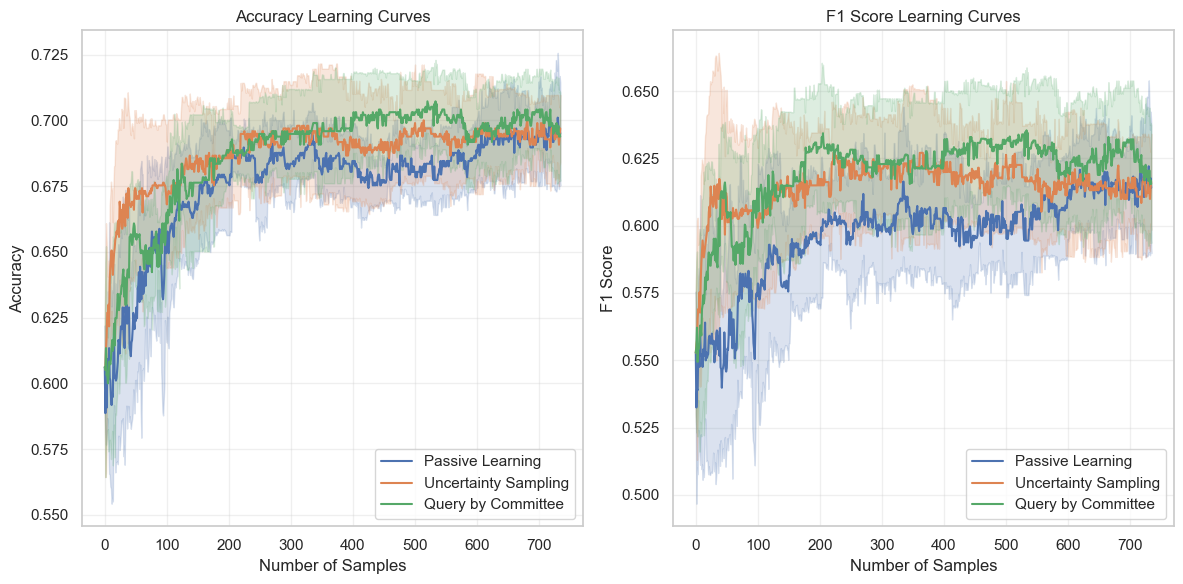

In [73]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

result_dict = {
    "Passive Learning": {
        "accuracy": accuracy_passive,
        "f1": f1_passive
    },
    "Uncertainty Sampling": {
        "accuracy": accuracy_uncertainty,
        "f1": f1_uncertainty
    },
    "Query by Committee": {
        "accuracy": accuracy_QBC,
        "f1": f1_QBC
    }
    # Add more groups as needed
}

plot_learning_curves(result_dict, save_path=None)